In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [27]:
df=pd.read_csv('AAPL.csv',usecols=['date','close'])

In [28]:
df


,date,close
0,2018-03-06 00:00:00+00:00,176.67
1,2018-03-07 00:00:00+00:00,175.03
2,2018-03-08 00:00:00+00:00,176.94
3,2018-03-09 00:00:00+00:00,179.98
4,2018-03-12 00:00:00+00:00,181.72
...,...,...
1253,2023-02-27 00:00:00+00:00,147.92
1254,2023-02-28 00:00:00+00:00,147.41
1255,2023-03-01 00:00:00+00:00,145.31
1256,2023-03-02 00:00:00+00:00,145.91


In [29]:
df['date'] = list(map(lambda x:x.split(" ")[0], df["date"]))

In [30]:
df

,date,close
0,2018-03-06,176.67
1,2018-03-07,175.03
2,2018-03-08,176.94
3,2018-03-09,179.98
4,2018-03-12,181.72
...,...,...
1253,2023-02-27,147.92
1254,2023-02-28,147.41
1255,2023-03-01,145.31
1256,2023-03-02,145.91


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1258 non-null   object 
 1   close   1258 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.8+ KB


In [32]:
# convert date colume to daetime type
import datetime
def str_to_datetime(s):
    split = s.split("-")
    year = int(split[0])
    month = int(split[1])
    day = int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

In [33]:
df['date'] = df['date'].apply(str_to_datetime)

In [34]:
df

,date,close
0,2018-03-06,176.67
1,2018-03-07,175.03
2,2018-03-08,176.94
3,2018-03-09,179.98
4,2018-03-12,181.72
...,...,...
1253,2023-02-27,147.92
1254,2023-02-28,147.41
1255,2023-03-01,145.31
1256,2023-03-02,145.91


In [35]:
df.index = df.pop('date')
df

,close
date,
2018-03-06,176.67
2018-03-07,175.03
2018-03-08,176.94
2018-03-09,179.98
2018-03-12,181.72
...,...
2023-02-27,147.92
2023-02-28,147.41
2023-03-01,145.31


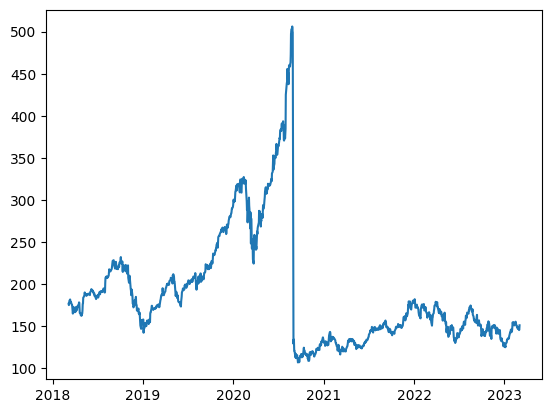

In [14]:
plt.plot(df['date'],df['close'])

In [64]:
# creating windowed function to create 3 consicutive column of data for LSTM

def df_to_windowed_df(dataframe, first_date: str, last_date: str, n=3):
    first_date = str_to_datetime(first_date)
    last_date = str_to_datetime(last_date)

    target_date = first_date

    dates = []
    X, Y = [], []

    last_time = False

    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != (n+1):
            print(f" Error first date shpuld be atlest 4TH date ")
            return

        values = df_subset['close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date +
                                  datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_day_str = next_datetime_str.split('T')[0]
        year_month_day = next_day_str.split("-")
        year, month, day = year_month_day
        next_date = datetime.datetime(
            day=int(day), month=int(month), year=int(year))

        if last_time:
            break

        target_date = next_date

        if target_date >= last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df
# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '2018-03-11',
                                '2020-03-23',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2018-03-11,176.67,175.03,176.94,179.98
1,2018-03-13,176.94,179.98,181.72,179.97
2,2018-03-14,179.98,181.72,179.97,178.44
3,2018-03-15,181.72,179.97,178.44,178.65
4,2018-03-16,179.97,178.44,178.65,178.02
...,...,...,...,...,...
507,2020-03-17,248.23,277.97,242.21,252.86
508,2020-03-18,277.97,242.21,252.86,246.67
509,2020-03-19,242.21,252.86,246.67,244.78
510,2020-03-20,252.86,246.67,244.78,229.24


In [55]:
import numpy as np


def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)

    target_date = first_date

    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(
                f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date +
                                  datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(
            day=int(day), month=int(month), year=int(year))

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df


# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '2018-03-11',
                                '2020-03-23',
                                n=3)
windowed_df


,Target Date,Target-3,Target-2,Target-1,Target
0,2018-03-11,176.67,175.03,176.94,179.98
1,2018-03-13,176.94,179.98,181.72,179.97
2,2018-03-14,179.98,181.72,179.97,178.44
3,2018-03-15,181.72,179.97,178.44,178.65
4,2018-03-16,179.97,178.44,178.65,178.02
...,...,...,...,...,...
507,2020-03-17,248.23,277.97,242.21,252.86
508,2020-03-18,277.97,242.21,252.86,246.67
509,2020-03-19,242.21,252.86,246.67,244.78
510,2020-03-20,252.86,246.67,244.78,229.24


In [ ]:


    X = np.array(X)
    for i in range(0,n):
        X[:,i]
        ret_df[f'Target-{n-i}'] = X[:,i]

    ret_df['Target'] = Y

    return ret_df

        
    

In [66]:
windowed_df = df_to_windowed_df(df,'2018-03-11','2020-03-08',n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2018-03-11,176.67,175.03,176.94,179.98
1,2018-03-13,176.94,179.98,181.72,179.97
2,2018-03-14,179.98,181.72,179.97,178.44
3,2018-03-15,181.72,179.97,178.44,178.65
4,2018-03-16,179.97,178.44,178.65,178.02
...,...,...,...,...,...
497,2020-03-03,273.52,273.36,298.81,289.32
498,2020-03-04,273.36,298.81,289.32,302.74
499,2020-03-05,298.81,289.32,302.74,292.92
500,2020-03-06,289.32,302.74,292.92,289.03


In [40]:
target_date = str_to_datetime("2022-03-01")
df_subset = df.loc[:target_date].tail(4)
print(df_subset)
len(df_subset)

             close
date              
2022-02-24  162.74
2022-02-25  164.85
2022-02-28  165.12
2022-03-01  163.20


4

In [43]:
import datetime

date = target_date+datetime.timedelta(days=7)
date



datetime.datetime(2022, 3, 8, 0, 0)

In [47]:
dataframe = df
next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
print(next_week,next_datetime_str)

             close
date              
2022-03-01  163.20
2022-03-02  166.56
2022-03-03  166.23
2022-03-04  163.17
2022-03-07  159.30
2022-03-08  157.44 2022-03-02T00:00:00.000000000
